# Проверка гипотез по увеличению выручки интернет-магазина

## Цели и задачи

Имеются данные крупного интернет-магазина. Аналитики и отдел маркетинга подготовили список гипотез для увеличения выручки.

**Цель исследования**
Приоритизирвать гипотезы, запустить A/B-тест и проанализировать результаты.

**Ход исследования**
Исследование пройдёт в несколько этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Приоритизация гипотез.
 4. Анализ A/B-теста.

## Обзор данных

In [1]:
#импорт всех необходимых библиотек

import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()


In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
orders = pd.read_csv('/datasets/orders.csv', sep=',')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [4]:
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


## Предобработка данных

In [5]:
#проверим данные hypothesis на пропуски и форматы
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
#приведем названия столбцов к змеиному регистру

hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
#проверим данные orders на пропуски и форматы
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
#преобразуем данные date в формат даты

orders['date'] = pd.to_datetime(
    orders['date'], format='%Y-%m-%dT'
)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
#прорверим данные на наличие явных дубликатов:
print('явных дубликатов:', orders.duplicated().sum())

явных дубликатов: 0


In [10]:
#проверим данные visitors на пропуски и форматы
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
#преобразуем данные date в формат даты

visitors['date'] = pd.to_datetime(
    visitors['date'], format='%Y-%m-%dT'
)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [12]:
#прорверим данные на наличие явных дубликатов:
print('явных дубликатов:', orders.duplicated().sum())

явных дубликатов: 0


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Данные приведены к нужным форматам, пропусков и дубликатов нет

## Приоритизация гипотез

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Приоретизируем гипотезы с помощью методов ICE и RICE. Для этого используем параметры:
    <br> Reach — скольких пользователей затронет изменение, которое хотим внести;
    <br> Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
    <br> Confidence — насколько мы уверены, что это изменение повлияет на пользователей именно так; 
    <br> Efforts — сколько стоит протестировать эту гипотезу.

In [13]:
#Применим фреймворк ICE для приоритизации гипотез

hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis['ICE'] = hypothesis['ICE'].astype(int)
pd.options.display.max_colwidth = 100
print(hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))

                                                                                            hypothesis  \
8                                              Запустить акцию, дающую скидку на товар в день рождения   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                     Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   
5             Добавить страницу отзывов клиент

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Наиболее перспективные гипотезы по ICE: 
    <br> Запустить акцию, дающую скидку на товар в день рождения   
    <br> Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
    <br> Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    <br> Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

In [14]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis['RICE'] = hypothesis['RICE'].astype(int)
pd.options.display.max_colwidth = 100
print(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

                                                                                            hypothesis  \
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
8                                              Запустить акцию, дающую скидку на товар в день рождения   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
4                     Изменить цвет фона главн

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Наиболее перспективные гипотезы по RICE: 
<br> Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
<br> Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек
<br> Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
<br> Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
<br>
<br> Приоритеты по RICE сменились относительно ICE, т к у двух ггипотез парметр Reach (сколько пользователей затронут изменения) макисмальный или близок к максимальному.

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 По итогам приоретизации наиболее перспективные гипотезы:
    <br> Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
    <br> Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек
    <br> Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
    <br> Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    <br> Запустить акцию, дающую скидку на товар в день рождения

## Анализ A/B-теста

In [15]:
#Соберём агрегированные кумулятивные по дням данные о заказах


print(orders.head(5))
print(visitors.head(5))

datesGroups = orders[['date', 'group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
 lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']) 
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head(5)) 

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     1650     B
1     2804400009  3642806036 2019-08-15      730     B
2     2961555356  4069496402 2019-08-15      400     A
3     3797467345  1196621759 2019-08-15     9759     B
4     2282983706  2322279887 2019-08-15     2308     B
        date group  visitors
0 2019-08-01     A       719
1 2019-08-02     A       619
2 2019-08-03     A       507
3 2019-08-04     A       717
4 2019-08-05     A       756
        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


In [16]:

users_both = (
    orders.groupby('visitorId', as_index=False)
    .agg({'group': 'nunique'}))
users_both = users_both.query('group > 1')
len(users_both['visitorId'])

58

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 58 пользователей присутствуют в обеих группах.Удалять не будем, т к поведение одного и того же пользователя может измениться под влиянием изменений на сайте  

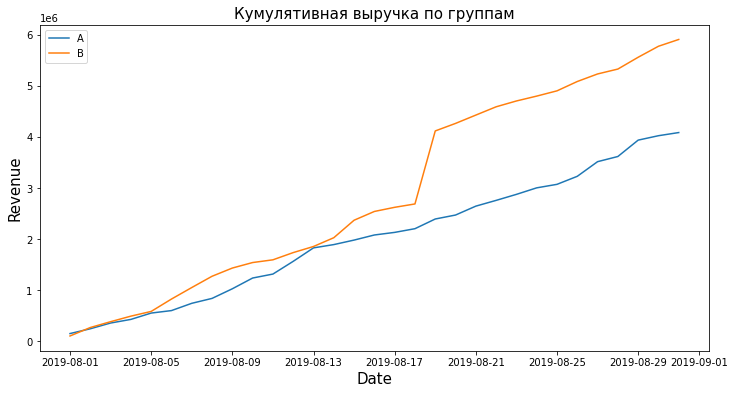

In [17]:
#Для отслеживания изменений результатов эксперимента на каждый день тестирования, построим график куммулятивных данных.
#Построим график кумулятивной выручки по группам.


# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.title('Кумулятивная выручка по группам', fontsize=15)


# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Графики в обеих группах постоянно растут. Половину периода выручка группы В растет чуть быстрее группы А, но затем в группе B произошел резкий скачок, и вторую половину периода накопительная выручка уже значительно превышала показатель группы А. Возможно был крупный заказ.    

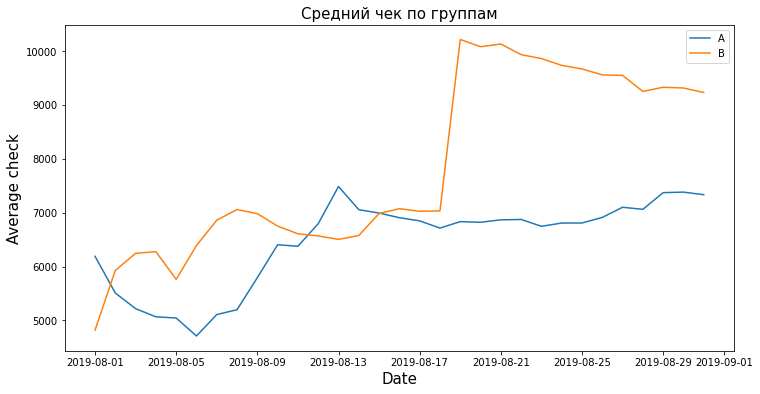

In [18]:
#Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.figure(figsize=(12,6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Average check', fontsize=15)
plt.title('Cредний чек по группам', fontsize=15)


plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Средний чек для группы А становится равномерным ближе к середине теста, график в самом начале показывает падение, затем резкий рост и с середины примерно на одном уровне с небольшими колебаниями. Группа B по среднему чеку большую часть периода превосходила группу А
<br> Для группы B был резкий скачок в начале, затем небольшое падение, и в середине теста уже наблюдаемый в предыдущем графике резкий рост, и далее небольшое плавное падение до конца периода.

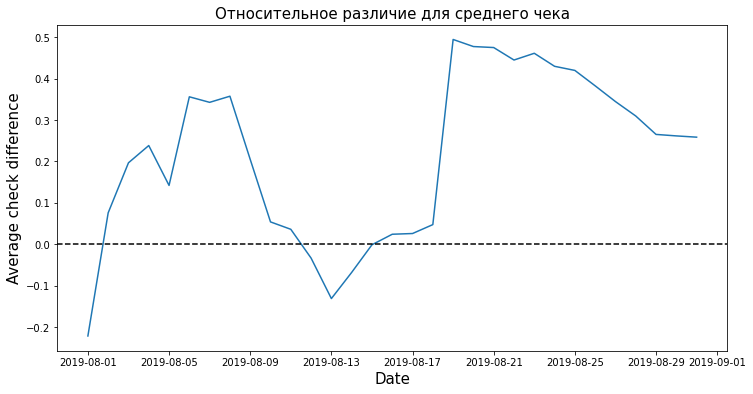

In [19]:
#Построим график относительного различия для среднего чека
plt.figure(figsize=(12,6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Average check difference', fontsize=15)
plt.title('Относительное различие для среднего чека', fontsize=15)

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 В нескольких точках график различия между сегментами резко падает или резко растет. В данных о заказах точно есть выбросы, найдём их позже.

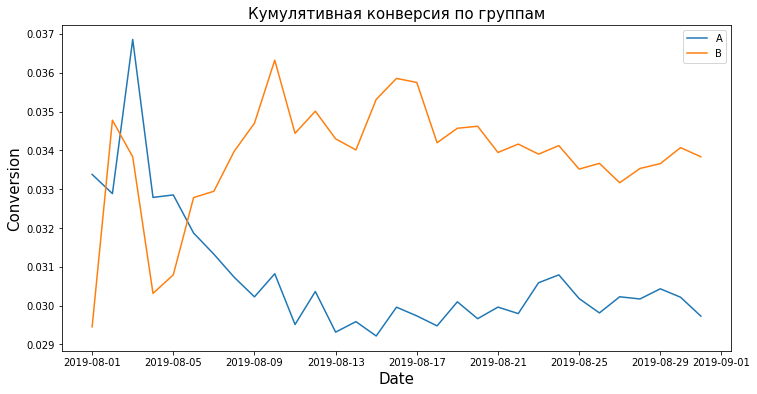

In [20]:
#Построим график кумулятивного среднего количества заказов на посетителя по группам, куммулятивной конверсии
plt.figure(figsize=(12,6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Conversion', fontsize=15)
plt.title('Кумулятивная конверсия по группам', fontsize=15)

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 в начале периода по количеству заказов превосходит группа А, для графиков в этот период характены резкие скачки, затем динамика стабилизируется. Группа B вскоре после первого падения показывает интенсивный рост, и далее стабилизируется только в самом конце периода. График конверсии группы А после периода стабилизации примерно на одном уровне.

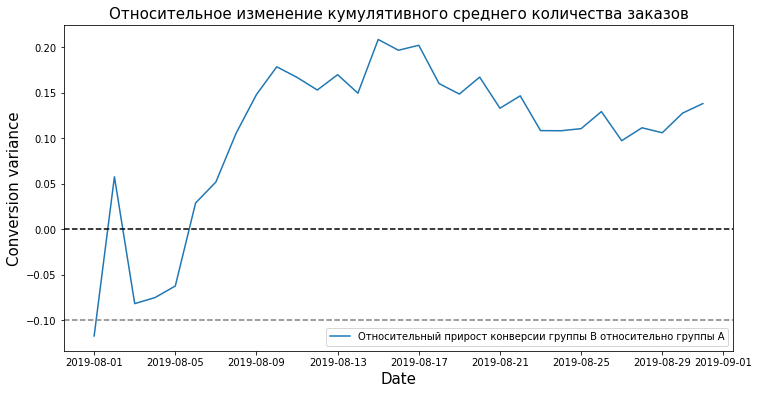

In [21]:
#Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Conversion variance', fontsize=15)
plt.title('Относительное изменение кумулятивного среднего количества заказов', fontsize=15)

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Сначала группа B сильно уступала в конверсии группе А, затем произошел резкий рост показателя в группе B, и он продолжился до конца периода
    

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


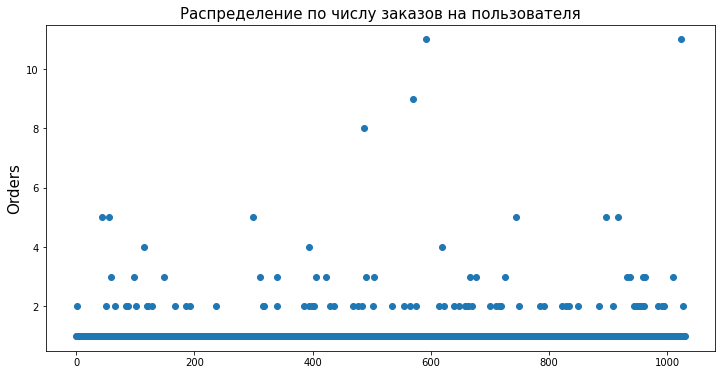

In [22]:
#построим диаграмму распределения для оценки выбросов в данных о заказах:

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(12,6))
plt.ylabel('Orders', fontsize=15)
plt.title('Распределение по числу заказов на пользователя', fontsize=15)

plt.scatter(x_values, ordersByUsers['orders']) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 На графике видны выбросы: несколько покупателей совершили более 8 заказов. Но бОльшая часть значений - это 1, также значительная часть покупателей сделали два заказа. Чем больше значение количества заказов на пользователя - тем меньше таких пользователей.

In [23]:
#Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Не более 5% пользователей сделали более 2 заказов и не более 1% - более 4 заказов. Порог аномального значения 4 заказа

       visitorId  revenue
463   1920142716  1294500
503   2108080724   202740
1023  4256040402   176490
1026  4266935830   157980
569   2378935119   142939
316   1316129916    94770
314   1307669133    92550
213    888512513    86620
744   3062433592    75459
186    759473111    72000


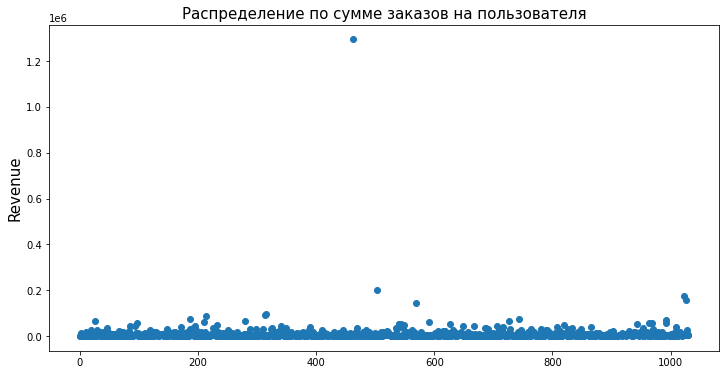

In [24]:
#построим диаграмму рассеяния для оценки выбросов в данных о сумме заказов:
revenueByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'revenue': 'sum'})
)
revenueByUsers.columns = ['visitorId', 'revenue']

print(revenueByUsers.sort_values(by='revenue', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в revenueByUsers
x_values = pd.Series(range(0, len(revenueByUsers)))

plt.figure(figsize=(12,6))
plt.ylabel('Revenue', fontsize=15)
plt.title('Распределение по сумме заказов на пользователя', fontsize=15)

plt.scatter(x_values, revenueByUsers['revenue']) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Очевидно вот и тот самый выброс, который поменял ход тестирования в группе B. Кто-то оформил заказы на сумму 1 294 500.В то время как основная масса заказов сосредоточена в дизапазонне значений до 100 тыс

In [25]:
#Посчитаем 95-й и 99-й перцентили суммы заказов на пользователя
print(np.percentile(revenueByUsers['revenue'], [90, 95, 99])) 

[19260.  32899.5 67750. ]


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Не более 5% пользователей сделали заказы на сумму более 32899,5 и не более 1% на сумму 67750. Порог аномального значения 32899,5 

In [26]:
#Посчитаем статистическую значимость различий в среднем числе заказов на пользователя
#между группами по «сырым» данным — без удаления аномальных пользователей.

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [27]:
#Посчитаем статистическую значимость различия в среднем количестве заказов между группам
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

In [28]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
  

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [29]:
#объединим последовательности
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

In [30]:
#передадим аргумент, сообщающий, что объекты Series нужно объединить по строкам 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Сформулируем нулевую и альтернативную гипотезы для различий в среднем числе заказов:
<br> H0: статистически значимых различий в среднем числе заказов между группами нет
<br> H1: между группами есть статистически значимые различия в среднем числе заказов    

In [31]:
#Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value =',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный выигрыш', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

p-value = 0.017
Относительный выигрыш 0.138


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13,8%.

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Сформулируем нулевую и альтернативную гипотезы для различий в среднем чеке между группами:
<br> H0: статистически значимых различий в среднем чеке между группами нет
<br> H1: между группами есть статистически значимые различия в среднем чеке    

In [32]:
# найдём относительные различия в среднем чеке между группами:
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный выигрыш','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.729
Относительный выигрыш 0.259


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 P-value 0.729 больше 0.05, значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B <b>равен</b> среднему чеку группы A (или не отличается или различия получены случайным образом).

In [33]:
#произведем аналогичные действия с очищенными от аномалий данными
#за аномалии приняли кол-во заказов более 4 и сумму более 32900

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 32899.5]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
928     204675465
684     358944393
648     382846391
751     689129267
Name: visitorId, dtype: int64
44


In [34]:
#Посчитаем потери пользователей после очитски данных от аномалий
abnormalUsers_count = abnormalUsers.shape[0]
abnormalUsers_share = len(abnormalUsers)/len(orders['visitorId'].unique())
print('абсолютные потери:', abnormalUsers_count)
print('относительные потери:', '{0:.3f}'.format(abnormalUsers_share))


абсолютные потери: 44
относительные потери: 0.043


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 всего 44 аномальных пользователя, что составляет 4% от общего числа. Доля не критичная. Узнаем, как их действия повлияли на результаты теста

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Сформулируем нулевую и альтернативную гипотезы о различиях в среднем числе заказов по очищенным данным::
<br> H0: В очищенных данных статистически значимых различий в среднем числе заказов между группами нет
<br> H1: В очищенных данных между группами есть статистически значимые различия в среднем числе заказов    

In [35]:
#Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#Применим статистический критерий Манна-Уитни к полученным выборкам:
print('p-value =','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный выигрыш','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value = 0.017
Относительный выигрыш 0.154


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Результаты по очищенным данным о количестве заказов поменялись незначительно. Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 15,4%. Изменятся ли результаты по среднему чеку?

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Сформулируем нулевую и альтернативную гипотезы для различий в среднем чеке по очищенным данным:
<br> H0: В очищенных данных статистически значимых различий в среднем чеке между группами нет
<br> H1: В очищенных данных между группами есть статистически значимые различия в среднем чеке    

In [36]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.831
0.014


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 P-value увеличился с 0.729 до 0.831, что по-прежнему больше 0,05,  значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B <b>равен</b> среднему чеку группы A (или не отличается или различия получены случайным образом).   

## Результат A/B-теста

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Результаты теста ка по сырым, так и по очищенным данным показали преимущество группы B в показателях количества заказов:
<br> По количеству заказов на пользователя по "сырым данным" группа B выигрывает на 13,8%, по очищенным от аномалий - на 15,4%.
<br> В динамике показатели выручки, числа заказов и конверсии также говорят в пользу группы B.
<br>  Исходя из обнаруженных фактов, тест следует остановить и признать, что при имеющихся данных сегмент B выигрывает у сегмента A.    